In [36]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import cross_val_score
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
url= 'https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv'
df = pd.read_csv(url, sep='\t')

In [38]:
df.shape

(156060, 4)

In [39]:
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [40]:
print(df.isnull().values.any())

False


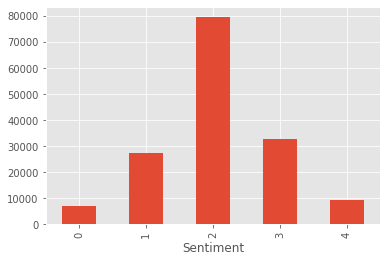

In [41]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
#To change the size
#fig = plt.figure(figsize=(7,6))
fig = df.groupby('Sentiment').Phrase.count().plot.bar(ylim=0)
#plt.show()
plt.savefig('/content/drive/My Drive/NLP Assignment 1/assgn2.png', format='png', dpi=1200)

In [0]:
# Assigning stemmers, lemmatizers, and more to variables
porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations="?:!.,;'\"-()"

# Parameters to adjust to see the impact on outcome
remove_stopwords = True
useStemming = False
useLemma = True
removePuncs = True

In [0]:
spacedReview = []
for x in range(0,len(df.PhraseId)):
  tmpReview = []
  for word in nltk.word_tokenize(df['Phrase'].values[x]):
    newWord = str(word).lower() #Converting the given word to lowercase 
    if remove_stopwords and (word in stopwords_en): #Remove the word if it is in stopwords_en
      continue
    if removePuncs and (word in punctuations): #Remove the word if it is a punctuation
      continue
    if useLemma: # Lemmatization
      newWord = wordnet_lemmatizer.lemmatize(newWord)
    if useStemming: # Stemming
      newWord = lancaster.stem(newWord)
    tmpReview.append(newWord)
  spacedReview.append(' '.join(tmpReview))

In [0]:
df['NewPhrase']=spacedReview

In [45]:
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment,NewPhrase
0,1,1,A series of escapades demonstrating the adage ...,1,a series escapade demonstrating adage good goo...
1,2,1,A series of escapades demonstrating the adage ...,2,a series escapade demonstrating adage good goose
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series
5,6,1,of escapades demonstrating the adage that what...,2,escapade demonstrating adage good goose
6,7,1,of,2,
7,8,1,escapades demonstrating the adage that what is...,2,escapade demonstrating adage good goose
8,9,1,escapades,2,escapade
9,10,1,demonstrating the adage that what is good for ...,2,demonstrating adage good goose


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df['NewPhrase'],df['Sentiment'], test_size=0.3, random_state=2003)

In [47]:
#Here, X_train and X_test will have mutually exclusive sets of 109242 and 46818 samples. 
print(X_train.shape)
print(X_test.shape)

(109242,)
(46818,)


In [48]:
Y_train.value_counts()

2    55595
3    23055
1    19203
4     6468
0     4921
Name: Sentiment, dtype: int64

In [0]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

# Transform each text into a vector of word counts
#For using Count Vectorizer
#vectorizer_tfid = CountVectorizer(stop_words="english",ngram_range=(1, 2), max_features = 3000)

#For using TF-IDF Vectorizer
vectorizer_tfid = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)


X = vectorizer_tfid.fit_transform(df['NewPhrase'])
Y = df['Sentiment']
x_train = vectorizer_tfid.transform(X_train)
y_train = Y_train
x_test = vectorizer_tfid.transform(X_test)
y_test = Y_test

In [50]:
x_train.shape, x_test.shape

((109242, 3000), (46818, 3000))

In [51]:
x_train

<109242x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 343594 stored elements in Compressed Sparse Row format>

In [52]:
# Converting the training data to NumPy array
x_train_np = x_train.toarray()
y_train_np = np.array(y_train)

# Converting the testing data to NumPy array
x_test_np = x_test.toarray()
y_test_np = np.array(y_test)

# Printing to see if it is converted properly
print(x_train_np.shape)
print(y_train_np.shape)

(109242, 3000)
(109242,)


In [53]:
# Reshaping the converted NumPy array
x_train_np=x_train_np.reshape(x_train_np.shape[0],x_train_np.shape[1],1)
x_test_np=x_test_np.reshape(x_test_np.shape[0],x_test_np.shape[1],1)
print(x_train_np.shape)
print(x_test_np.shape)

y_train_np = to_categorical(y_train_np)
print(y_train_np.shape)
y_test_np = to_categorical(y_test_np)
print(y_test_np.shape)

(109242, 3000, 1)
(46818, 3000, 1)
(109242, 5)
(46818, 5)


In [0]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0 ,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0 ,1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Conv1D, Flatten, Dropout
from keras.layers import Activation, AveragePooling1D
from keras import optimizers 

In [0]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_np.shape[1],x_train_np.shape[2])))
model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [0]:
# If we want to define the hyperarameters
newopt = optimizers.Adam(lr=0.0007)

In [58]:
# Used for compiling the model
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2998, 64)          256       
_________________________________________________________________
average_pooling1d_2 (Average (None, 1499, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 95936)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 479685    
Total params: 479,941
Trainable params: 479,941
Non-trainable params: 0
_________________________________________________________________


In [59]:
answer = model.fit(x_train_np, y_train_np, epochs=20, verbose=1, validation_split=0.2, batch_size = 512)

Train on 87393 samples, validate on 21849 samples
Epoch 1/20
87393/87393 [==============================] - 7s 79us/step - loss: 1.2008 - acc: 0.5284 - f1_m: 0.3717 - precision_m: 0.5366 - recall_m: 0.3163 - val_loss: 1.0823 - val_acc: 0.5661 - val_f1_m: 0.5207 - val_precision_m: 0.6487 - val_recall_m: 0.4350
Epoch 2/20
87393/87393 [==============================] - 6s 74us/step - loss: 1.0397 - acc: 0.5914 - f1_m: 0.5332 - precision_m: 0.6695 - recall_m: 0.4448 - val_loss: 1.0461 - val_acc: 0.5844 - val_f1_m: 0.5480 - val_precision_m: 0.6503 - val_recall_m: 0.4738
Epoch 3/20
87393/87393 [==============================] - 6s 74us/step - loss: 1.0056 - acc: 0.6033 - f1_m: 0.5531 - precision_m: 0.6765 - recall_m: 0.4689 - val_loss: 1.0274 - val_acc: 0.5937 - val_f1_m: 0.5503 - val_precision_m: 0.6646 - val_recall_m: 0.4698
Epoch 4/20
87393/87393 [==============================] - 6s 74us/step - loss: 0.9838 - acc: 0.6132 - f1_m: 0.5675 - precision_m: 0.6846 - recall_m: 0.4851 - val_loss:

In [60]:
# For saving the model
!apt-get install libhdf5-serial-dev
import h5py
model.save('/content/drive/My Drive/NLP Assignment 1/0889445_1dconv_reg.h5')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libhdf5-serial-dev is already the newest version (1.10.0-patch1+docs-4).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
# For loading the model
from keras.models import load_model
!apt-get install libhdf5-serial-dev
import h5py
model = load_model('/content/drive/My Drive/NLP Assignment 1/0889445_1dconv_reg.h5', custom_objects={'f1_m': f1_m,'precision_m':precision_m,'recall_m':recall_m})

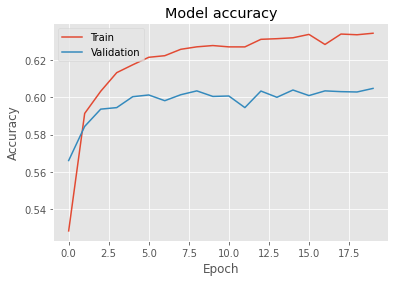

In [61]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values
plt.plot(answer.history['acc'])
plt.plot(answer.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#plt.savefig('/content/drive/My Drive/NLP Assignment 1/Accuracy_Epoch.png', format='png', dpi=1200)


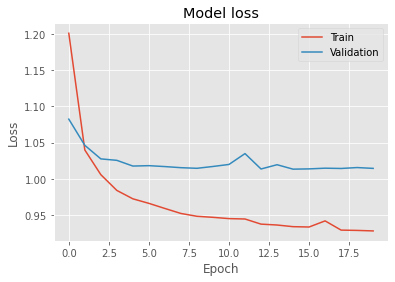

In [62]:

# Plot training & validation loss values
plt.plot(answer.history['loss'])
plt.plot(answer.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('/content/drive/My Drive/NLP Assignment 1/Loss_Epoch.png', format='png', dpi=1200)

In [63]:
# Testing the results
print(model.metrics_names)
model.evaluate(x_test_np, y_test_np)

['loss', 'acc', 'f1_m', 'precision_m', 'recall_m']
46818/46818 [==============================] - 5s 97us/step


[1.0130354019011696,
 0.6066042974924174,
 0.5673004735860043,
 0.663431084167749,
 0.4976718356187791]